In [1]:
import os
import keras
import pickle
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from dtw import *
from tqdm import tqdm_notebook as tqdm

Using TensorFlow backend.
/home/curt/analysisEnv/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/curt/analysisEnv/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/curt/analysisEnv/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/curt/analysisEnv/lib/python3.6/site-packages/tenso

Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.



In [2]:
def visualize_labels(y, alt=False):
    color = 'cividis' if alt else 'plasma'
    
    idx = np.arange(len(y))

    fig, ax1 = plt.subplots()

    im = ax1.imshow(y[np.newaxis,:], cmap=color, aspect="auto")
    ax1.set_yticks([])
    fig.colorbar(im, ax=ax1)

    plt.tight_layout()
    plt.show()

In [3]:
def visualize_matrix(Y, alt=False):
    color = 'cividis' if alt else 'plasma'
    
    fig, ax1 = plt.subplots()
    
    im = ax1.imshow(Y, cmap=color, interpolation='nearest', aspect="auto")
    fig.colorbar(im, ax=ax1)
    
    plt.tight_layout()
    plt.show()

In [4]:
model_path = './models/{0}/'.format('task1_sandwich_openface')

task_name = 'task1_sandwich_openface'

path = './data/openface/{0}/'.format(task_name)

#pair = ('0101_sandwich_cut.csv','0102_sandwich_cut.csv')
pair = ('0301_sandwich_cut.csv','0302_sandwich_cut.csv')
#pair = ('0501_sandwich_cut.csv','0502_sandwich_cut.csv')

In [5]:
indicies = ['x_{0}'.format(i) for i in range(0,68)] + ['y_{0}'.format(i) for i in range(0,68)]

df1 = pd.read_csv(os.path.join(path,pair[0]), error_bad_lines=False, warn_bad_lines=True)
face_lmk_1 = df1[indicies]

nans = df1[df1[indicies].isnull().any(axis=1)]
if not nans.empty:
    dropList = nans.index.tolist()
    for r in dropList:
        warnings.warn('Dropping row due to NaN, {0}'.format(r))
    face_lmk_1.drop(dropList, inplace=True)

face_lmk_1.head()

,x_0,x_1,x_2,x_3,x_4,x_5,x_6,x_7,x_8,x_9,...,y_58,y_59,y_60,y_61,y_62,y_63,y_64,y_65,y_66,y_67
0,934.7,937.6,944.8,954.0,966.3,982.6,1003.7,1029.1,1061.7,1098.1,...,860.6,858.2,848.9,841.3,840.4,839.2,845.0,840.4,841.9,841.5
1,927.9,930.2,936.4,944.6,955.7,971.1,991.8,1016.7,1048.8,1084.8,...,862.4,860.5,852.6,843.9,842.9,841.5,848.1,843.3,844.8,844.3
2,921.6,922.3,927.8,936.3,947.2,962.0,982.9,1007.7,1039.6,1074.1,...,865.5,863.8,856.2,846.9,846.0,844.6,850.7,845.9,847.5,846.9
3,916.1,915.4,921.0,930.7,941.4,955.7,975.4,1000.6,1031.5,1064.7,...,867.5,865.3,857.3,849.8,849.1,847.9,852.2,848.5,850.0,849.6
4,907.9,907.4,913.8,924.3,934.8,949.2,968.8,994.4,1025.2,1057.9,...,869.2,867.3,858.8,851.3,850.6,849.4,853.8,849.5,851.1,850.9


In [6]:
X1 = np.asarray(face_lmk_1.to_numpy()).astype('float32')
print(X1.shape)

(8261, 136)


In [7]:
df2 = pd.read_csv(os.path.join(path,pair[1]), error_bad_lines=False, warn_bad_lines=True)
face_lmk_2 = df2[indicies]

nans = df2[df2[indicies].isnull().any(axis=1)]
if not nans.empty:
    dropList = nans.index.tolist()
    for r in dropList:
        warnings.warn('Dropping row due to NaN, {0}'.format(r))
    face_lmk_2.drop(dropList, inplace=True)

face_lmk_2.head()

,x_0,x_1,x_2,x_3,x_4,x_5,x_6,x_7,x_8,x_9,...,y_58,y_59,y_60,y_61,y_62,y_63,y_64,y_65,y_66,y_67
0,750.0,744.2,742.9,747.3,752.9,759.0,764.7,770.6,785.4,809.7,...,735.0,730.3,722.8,722.8,724.2,724.4,725.9,725.8,725.1,723.2
1,748.7,742.6,741.8,747.2,752.8,759.1,763.8,769.4,784.4,808.1,...,735.6,730.6,723.3,723.6,725.2,725.7,726.9,727.0,726.0,723.9
2,748.1,742.0,741.0,746.5,752.4,758.9,764.0,769.7,784.6,808.2,...,736.5,731.4,723.9,724.4,726.0,726.5,727.5,728.0,727.0,724.9
3,748.0,742.0,741.2,746.7,752.6,759.2,764.3,770.0,784.9,808.6,...,737.5,732.2,724.7,725.4,727.1,727.6,728.4,728.9,728.0,725.8
4,747.8,741.8,741.2,746.7,752.6,759.3,764.6,770.3,785.1,808.7,...,737.9,732.8,725.4,725.8,727.4,727.9,728.6,729.2,728.4,726.2


In [8]:
X2 = np.asarray(face_lmk_2.to_numpy()).astype('float32')
print(X2.shape)

(8333, 136)


## UMAP Direct

In [11]:
# scikit-learn v0.24.1
umap_3 = pickle.load(open(model_path+'umap_3.p','rb'))

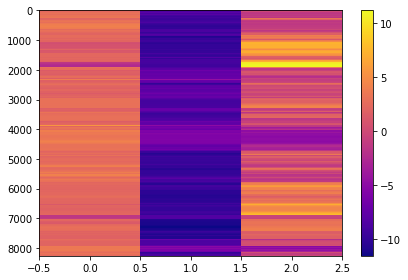

In [12]:
tl1 = umap_3.transform(X1)
visualize_matrix(tl1)

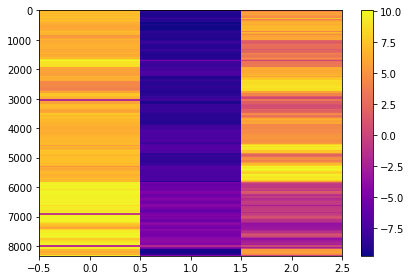

In [13]:
tl2 = umap_3.transform(X2)
visualize_matrix(tl2)

In [14]:
alignment = dtw(tl2, tl1, keep_internals=True, open_begin=True, open_end=True, step_pattern='asymmetric')

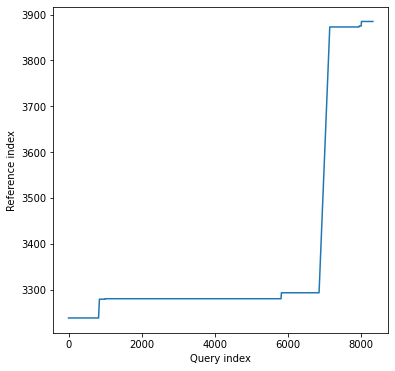

<AxesSubplot:xlabel='Query index', ylabel='Reference index'>

In [15]:
alignment.plot('alignment')

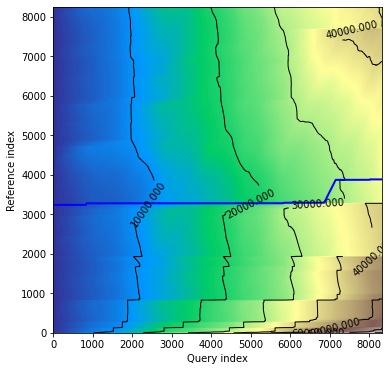

<AxesSubplot:xlabel='Query index', ylabel='Reference index'>

In [16]:
alignment.plot('density')

## PCA UMAP

In [17]:
# scikit-learn v0.24.1
PCA_n_32 = pickle.load(open(model_path + 'pca_n_32.p', 'rb'))
umap_3 = pickle.load(open(model_path+'umap_3_pca_32.p','rb'))

Thu Apr 22 23:23:46 2021 Building and compiling search function


	completed  0  /  100 epochs
	completed  10  /  100 epochs
	completed  20  /  100 epochs
	completed  30  /  100 epochs
	completed  40  /  100 epochs
	completed  50  /  100 epochs
	completed  60  /  100 epochs
	completed  70  /  100 epochs
	completed  80  /  100 epochs
	completed  90  /  100 epochs


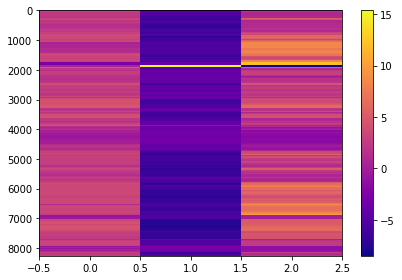

In [18]:
tl1 = umap_3.transform(PCA_n_32.transform(X1))
visualize_matrix(tl1)

	completed  0  /  100 epochs
	completed  10  /  100 epochs
	completed  20  /  100 epochs
	completed  30  /  100 epochs
	completed  40  /  100 epochs
	completed  50  /  100 epochs
	completed  60  /  100 epochs
	completed  70  /  100 epochs
	completed  80  /  100 epochs
	completed  90  /  100 epochs


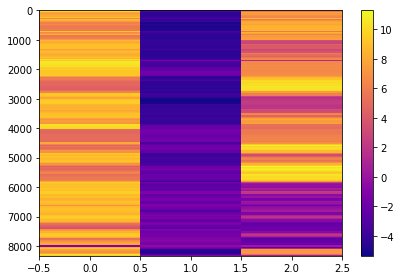

In [19]:
tl2 = umap_3.transform(PCA_n_32.transform(X2))
visualize_matrix(tl2)

In [20]:
alignment = dtw(tl2, tl1, keep_internals=True, open_begin=True, open_end=True, step_pattern='asymmetric')

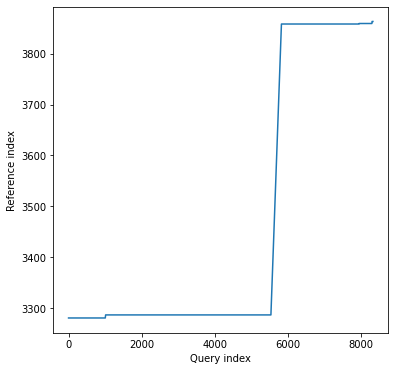

<AxesSubplot:xlabel='Query index', ylabel='Reference index'>

In [21]:
alignment.plot('alignment')

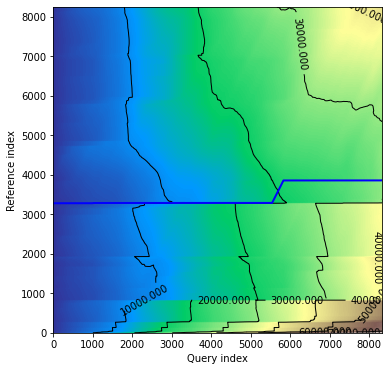

<AxesSubplot:xlabel='Query index', ylabel='Reference index'>

In [22]:
alignment.plot('density')

## Autoencoder UMAP

In [9]:
import keras
Encoder_32 = keras.models.load_model('./models/all_data/alt_encoder_32.h5')

Instructions for updating:
Colocations handled automatically by placer.


/home/curt/analysisEnv/lib/python3.6/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [10]:
umap_3 = pickle.load(open(model_path+'umap_3_enc_32.p','rb'))

Thu Apr 22 23:30:43 2021 Building and compiling search function


	completed  0  /  100 epochs
	completed  10  /  100 epochs
	completed  20  /  100 epochs
	completed  30  /  100 epochs
	completed  40  /  100 epochs
	completed  50  /  100 epochs
	completed  60  /  100 epochs
	completed  70  /  100 epochs
	completed  80  /  100 epochs
	completed  90  /  100 epochs


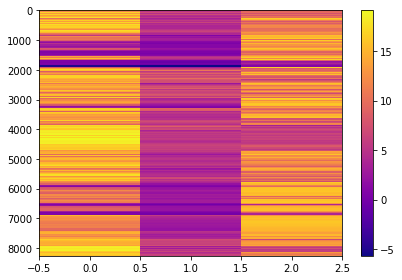

In [11]:
tl1 = umap_3.transform(Encoder_32.predict(X1))
visualize_matrix(tl1)

	completed  0  /  100 epochs
	completed  10  /  100 epochs
	completed  20  /  100 epochs
	completed  30  /  100 epochs
	completed  40  /  100 epochs
	completed  50  /  100 epochs
	completed  60  /  100 epochs
	completed  70  /  100 epochs
	completed  80  /  100 epochs
	completed  90  /  100 epochs


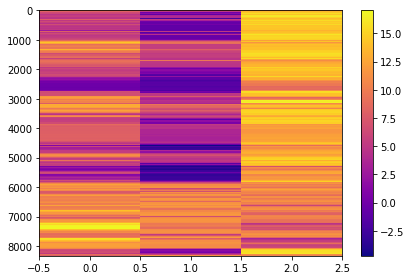

In [12]:
tl2 = umap_3.transform(Encoder_32.predict(X2))
visualize_matrix(tl2)

In [13]:
alignment = dtw(tl2, tl1, keep_internals=True, open_begin=True, open_end=True, step_pattern='asymmetric')

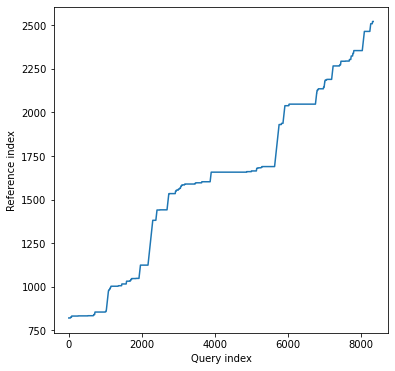

<AxesSubplot:xlabel='Query index', ylabel='Reference index'>

In [14]:
alignment.plot('alignment')

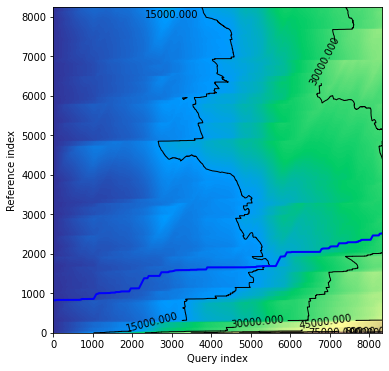

<AxesSubplot:xlabel='Query index', ylabel='Reference index'>

In [15]:
alignment.plot('density')